In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
from skimage import io
import os
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Preparing our Data

In [ ]:
DATA_PATH = '/content/drive/My Drive/Gesture Recognition/'

In [ ]:
shape_to_label = {'rock':np.array([1.,0.,0.,0.]),'paper':np.array([0.,1.,0.,0.]),'scissor':np.array([0.,0.,1.,0.]),'ok':np.array([0.,0.,0.,1.])}
arr_to_shape = {np.argmax(shape_to_label[x]):x for x in shape_to_label.keys()}

In [ ]:
imgData = list()
labels = list()

In [ ]:
for dr in os.listdir(DATA_PATH):
    if dr not in ['rock','paper','scissor']:
        continue
    print(dr)
    lb = shape_to_label[dr]
    i = 0
    for pic in os.listdir(os.path.join(DATA_PATH,dr)):
        path = os.path.join(DATA_PATH,dr+'/'+pic)
        img = cv2.imread(path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        imgData.append([img,lb])
        imgData.append([cv2.flip(img, 1),lb]) #horizontally flipped image
        imgData.append([cv2.resize(img[25:200,25:200],(300,300)),lb]) # zoom : crop in and resize
        i+=3
    print(i)

paper
900
rock
900
scissor
900


In [ ]:
np.random.shuffle(imgData)

In [ ]:
imgData,labels = zip(*imgData)

In [ ]:
imgData = np.array(imgData)
labels = np.array(labels)

Model

In [ ]:
from keras.models import Sequential,load_model
from keras.layers import Dense,MaxPool2D,Dropout,Flatten,Conv2D,GlobalAveragePooling2D,Activation
from keras.applications import DenseNet121
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.applications.densenet import DenseNet121
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


DenseNet

In [ ]:
densenet = DenseNet121(include_top=False, weights='imagenet', classes=3,input_shape=(300,300,3))
densenet.trainable=True

29089792/29084464 [==============================] - 1s 0us/step


In [ ]:
def genericModel(base):
    model = Sequential()
    model.add(base)
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(4,activation='softmax'))
    model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['acc'])
    return model

In [ ]:
dnet = genericModel(densenet)

In [ ]:
dnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 9, 9, 1024)        7037504   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 1024)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 65540     
Total params: 7,103,044
Trainable params: 7,019,396
Non-trainable params: 83,648
_________________________________________________________________


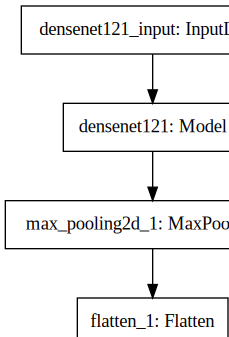

In [ ]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(dnet).create(prog='dot', format='svg'))

In [ ]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True,
    mode='auto'
)

In [ ]:
es = EarlyStopping(patience = 3)

In [ ]:
history = dnet.fit(
    x=imgData,
    y=labels,
    batch_size = 16,
    epochs=8,
    callbacks=[checkpoint,es],
    validation_split=0.2
)

Train on 2160 samples, validate on 540 samples
Epoch 1/8
2160/2160 [==============================] - 49s 23ms/step - loss: 0.2938 - acc: 0.9412 - val_loss: 3.6308 - val_acc: 0.7333

Epoch 00001: val_acc improved from -inf to 0.73333, saving model to model.h5
Epoch 2/8
2160/2160 [==============================] - 24s 11ms/step - loss: 0.1066 - acc: 0.9782 - val_loss: 65.3290 - val_acc: 0.6241

Epoch 00002: val_acc did not improve from 0.73333
Epoch 3/8
2160/2160 [==============================] - 24s 11ms/step - loss: 0.0190 - acc: 0.9926 - val_loss: 5.2434e-04 - val_acc: 1.0000

Epoch 00003: val_acc improved from 0.73333 to 1.00000, saving model to model.h5
Epoch 4/8
2160/2160 [==============================] - 24s 11ms/step - loss: 0.0137 - acc: 0.9954 - val_loss: 0.0024 - val_acc: 1.0000

Epoch 00004: val_acc did not improve from 1.00000
Epoch 5/8
2160/2160 [==============================] - 24s 11ms/step - loss: 0.0052 - acc: 0.9981 - val_loss: 0.5199 - val_acc: 0.8278

Epoch 00005

In [ ]:
 dnet.save_weights('model.h5')

In [ ]:
with open("model.json", "w") as json_file:
    json_file.write(dnet.to_json())